<a href="https://colab.research.google.com/github/kalathomas083/thinkful-capstone/blob/master/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction

Twitter has become a common way for people to communicate. Many influtential people, including the President of the United States, now make announcements using the medium. 

Is it possible for us to use this incredible data source to understand how people are feeling. For example the COVID pandemic has wreaked havoc on our lives and our economy. People are the key to the spread of the disease so could tweets be used to flesh out where there are pockets of people with negative sentiments about covid in order to focus a public health campaign?

# 2. Hypothesis

Twitter sentiment analysis could be used to determine the population's ideas about various topics.

# 3. Data

The dataset was taken from Kaggle. There are 1.6 million tweets labaled with sentiments.

https://www.kaggle.com/kazanova/sentiment140

# 4. Model creation

## Data setup

In [ ]:
!python -m spacy download en
!pip install contractions
!pip install httplib2==0.15.0
import re
import pickle
from sklearn.externals import joblib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import sklearn
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA #for PCA
import warnings
import contractions
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm # sm.results()

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
import spacy
import string
from wordcloud import WordCloud
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


Mount Google drive so the tweet data can be imported directly

In [ ]:
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  mypydrive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The data have no columns so need to create names and match to import.

In [ ]:
column_names = ['sentiment','id','date_time','query','user_name','text']
df = pd.read_csv('/content/drive/My Drive/Thinkful/Homework Assignments/Final Capstone/Tweets/training.1600000.processed.noemoticon.csv', encoding='latin-1',names=column_names)

The 'query' or 'id' features aren't useful here so I'll drop them.

In [ ]:
df.drop(['query','id'],axis=1, inplace=True)
df.dropna(subset=['sentiment','text'],inplace=True)

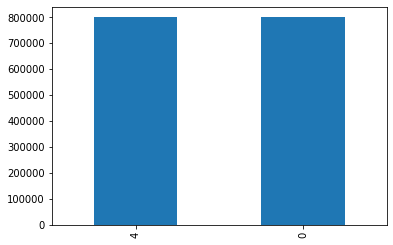

In [ ]:
# Look at the number of unique values for each column
df.sentiment.value_counts().plot(kind='bar')

Taking a look at the division of sentiments there is an even split between 4 (positive) and 0 (negative). I don't think 0 and 4 make sense as labels so I'm going to map 0's and 1's.

In [ ]:
df.sentiment = df.sentiment.map({0: 0, 4: 1})

Due to limited resources, I can't process 1.6 million tweets so I'm going to take a subset. I want the tweets to still be evenly split so I'm going to separate the tweets by sentiment, pull the desired number and combine them back together.

In [ ]:
def get_sample(df, sample_size):
  '''
  This function takes 2 data frames and a requested sample size size and splits
  the data frames evenly and then combines them returning one data frame with
  a row number = to the sample size requested.
  '''
  negative_tweets = df.loc[df['sentiment'] == 0]
  positive_tweets = df.loc[df['sentiment'] == 1]
  sample_half = int(sample_size / 2)
  # df_sample1 = df1.sample(n=sample_half)
  # df_sample2 = df2.sample(n=sample_half)
  df_sample1 = negative_tweets.head(sample_half)
  df_sample2 = positive_tweets.head(sample_half)
  df_sample = pd.concat([df_sample1,df_sample2])
  df_sample.reset_index(drop=True, inplace=True)
  return df_sample

df_sample = get_sample(df, 5000)
df_sample.sentiment.value_counts()

1    2500
0    2500
Name: sentiment, dtype: int64

## Text cleaning

Next I need to clean the text by removing punctuation, mentions, hyperlinks and other various problems presented by tweets.

In [ ]:
# Text cleaning
def text_cleaner(this_text):
  '''
  This function takes text and cleans it for text analysis.
  '''
  text = this_text.copy()
  for i in range(text.shape[0]):
    text.iloc[i] = re.sub(r"&quot;", "\"", text.iloc[i])
    text.iloc[i] = re.sub(r"(http://)\S+", " ", text.iloc[i])
    text.iloc[i] = re.sub(r"[;:][A-Z]", " ", text.iloc[i])
    text.iloc[i] = re.sub(r"@\S+", " ", text.iloc[i])
    text.iloc[i] = re.sub(r" - ", " ", text.iloc[i])
    text.iloc[i] = re.sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text.iloc[i])
    text.iloc[i] = re.sub(r"\+", " plus ", text.iloc[i])
    text.iloc[i] = re.sub(r",", " ", text.iloc[i])
    text.iloc[i] = re.sub(r"\.", " ", text.iloc[i])
    text.iloc[i] = re.sub(r"!", " ", text.iloc[i])
    text.iloc[i] = re.sub(r"\?", " ", text.iloc[i])
    text.iloc[i] = re.sub(r"\S*\d+\S*", " ", text.iloc[i])
    text.iloc[i] = re.sub(r"(.)\1{2,}", r"\1\1", text.iloc[i])
    text.iloc[i] = re.sub(r"\S*:\S*", " : ", text.iloc[i])
    text.iloc[i] = re.sub(r"\s{2,}", " ", text.iloc[i])
    text.iloc[i] = re.sub(r"[^\x00-\x7F]+", " ", text.iloc[i])
    text.iloc[i] = text.iloc[i].strip().lower()
  return text

df_sample['cleaned'] = text_cleaner(df_sample.text)

I'm going to use spacy to remove stop words and any remaining punctuation. Additionally I'm going to expand contractions in order to get a better look at the data.

In [ ]:
# Load spacy NLP model
nlp = spacy.load('en')

# Apply model to each row of the dataframe
df_sample['spacy'] = df_sample['cleaned'].apply(lambda x: nlp(' '.join([contractions.fix(word) for word in x.split()])))

def nlp_cleaner(df,column='spacy'):
  '''
  takes the data from the specified spacy column to remove stop words and 
  punctuation. The data overwrites the 'cleaned' dataframe
  '''
  for i, sentence in enumerate(df[column]):
    current_one = df.loc[i, column]
    this_sentence = []
    for token in current_one:
      if not token.is_stop and not token.is_punct:
        this_sentence.append(token.lemma_)
    this_sentence = ' '.join(this_sentence)
    df.loc[i, "cleaned"] = this_sentence
  return df

cleaned_df = nlp_cleaner(df_sample)

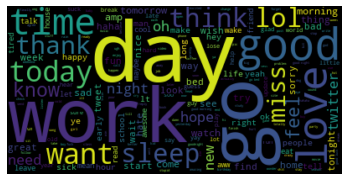

In [ ]:
# Combine the cleaned tweets to one string
tweets_as_str = " ".join(cleaned_df.cleaned)

# Create and show word cloud
wordcloud = WordCloud().generate(tweets_as_str)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Text(0, 0.5, 'Counts')

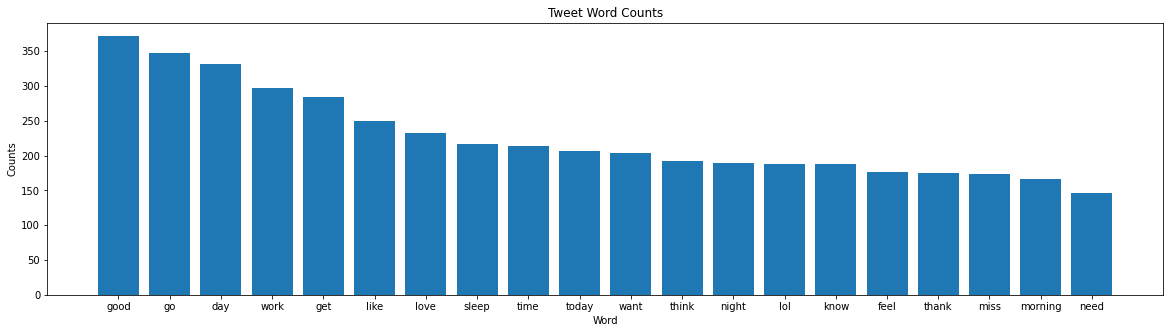

In [ ]:
# Convert one string to list of words
wordlist = tweets_as_str.split()

# Count the frequency in wordlist
word_counter = Counter(wordlist)
# Find the 20 most common
highest = word_counter.most_common(20)

# Sort by count descending
highest.sort(key=lambda x: x[1], reverse=True)
# Split the tuples for graphing
word, counts = zip(*highest)

# Graph the frequency
plt.figure(figsize=(20,5))
plt.bar(word, counts)
plt.title('Tweet Word Counts')
plt.xlabel('Word')
plt.ylabel('Counts')

## Word vectorizing

In [ ]:
# Function to convert dataframe to sparse array
def convert_to_sparse_pandas(df, exclude_columns=[]):
    """
    Converts columns of a data frame into SparseArrays and returns the data frame with transformed columns.
    Use exclude_columns to specify columns to be excluded from transformation.
    :param df: pandas data frame
    :param exclude_columns: list
        Columns not be converted to sparse
    :return: pandas data frame
    """
    df = df.copy()
    exclude_columns = set(exclude_columns)

    for (columnName, columnData) in df.iteritems():
        if columnName in exclude_columns:
            continue
        df[columnName] = pd.SparseArray(columnData.values, dtype='uint8')

    return df

In [ ]:
def words_to_numbers(df,column):
  '''
  Converts the specified column from words to various numbers
  including bag of words ngram(1,2), TF-IDF, and Word2Vec. The data is then converted
  to a sparse array using the convert_to_sparse_pandas above.
  It also combines each into one master sparse array.
  '''
  # Bag of Words
  vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,2))
  X = vectorizer.fit_transform(df[column])
  bow_arr = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
  bow_df = pd.concat([df.sentiment,bow_arr], axis=1)
  bow_df.dropna(inplace=True)
  bow_df = convert_to_sparse_pandas(bow_df) #convert to sparse array
  bow_df = bow_df.T.drop_duplicates().T #drop duplicates

  # TF-IDF
  vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english', use_idf=True, norm=u'l2', smooth_idf=True)
  X = vectorizer.fit_transform(df[column])
  tfidf_arr = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
  tfidf_df = pd.concat([df.sentiment, tfidf_arr], axis=1)
  tfidf_df.dropna(inplace=True)
  tfidf_df = convert_to_sparse_pandas(tfidf_df)

  # Word2Vec
  sample_size = 100
  model = gensim.models.Word2Vec(
    df[column],
    workers=4,
    min_count=1,
    window=6,
    sg=0,
    sample=1e-3,
    size=sample_size,
    hs=1
  )
  word2vec_arr = np.zeros((df.shape[0],sample_size))
  for i, sentence in enumerate(df[column]):
      word2vec_arr[i,:] = np.mean([model[lemma] for lemma in sentence], axis=0)
  word2vec_arr = pd.DataFrame(word2vec_arr)
  w2v_df = pd.concat([df.sentiment,word2vec_arr], axis=1)
  w2v_df.dropna(inplace=True)
  w2v_df = convert_to_sparse_pandas(w2v_df)

  # All DF
  all_df = pd.concat([df.sentiment,tfidf_arr,word2vec_arr,bow_arr], axis=1)
  all_df.dropna(inplace=True)
  all_df = convert_to_sparse_pandas(all_df)
  all_df = all_df.T.drop_duplicates().T

  return bow_df, tfidf_df, w2v_df, all_df

bow_df, tfidf_df, w2v_df, all_df = words_to_numbers(df_sample,'cleaned')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: The pandas.SparseArray class is deprecated and will be removed from pandas in a future version. Use pandas.arrays.SparseArray instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: The pandas.SparseArray class is deprecated and will be removed from pandas in a future version. Use pandas.arrays.SparseArray instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: The panda

In [ ]:
def super_dump(variable_list):
  '''
  This function takes a list of variables as strings and then performs
  pickle dump and uploads to the pickle dump folder in Google drive
  '''
  # PyDrive setup
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  mypydrive = GoogleDrive(gauth)

  # Loop through list
  for variable in variable_list:
    pickle.dump( globals()['%s' % variable], open( variable+'.pkl', "wb" ) )
    file = mypydrive.CreateFile({'parents': [{'id': '1cNKHSFu8hHdqjBx79Kv22V9nGpTwBVlG'}], 'title': variable+'.pkl'})
    file.SetContentFile(variable+'.pkl')
    file.Upload() 

In [ ]:
super_dump_variables = ['bow_df', 'tfidf_df', 'w2v_df', 'all_df']
super_dump(super_dump_variables)

In [ ]:
def super_load(variable_list):
  '''
  This function takes a list of variables as strings and then finds the file
  in Google drive and downloads the file back into variables
  '''
  # PyDrive setup
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  mypydrive = GoogleDrive(gauth)

  # Loop through list
  for variable in variable_list:
    # file = mypydrive.CreateFile({'parents': [{'id': '10qfuAXMkIv3gw5Hk9NUZW5gd-X5l1JvI'}], 'title': variable+'.pkl'})
    # file.SetContentFile(variable+'.pkl')
    globals()['%s' % variable] = pickle.load( open( variable+'.pkl', "rb" ) )
    # print(globals()['testing%s' % variable])

dump_dfs = ['bow_df', 'tfidf_df', 'w2v_df', 'all_df']
super_load(dump_dfs)

## Model functions

In [ ]:
# globals()['model%s' % variable_number]
def lr_maker(df,target):
  # '''
  # This function splits requested data into X and Y and then again
  # into test, train split. The data is then run through a logistic regression
  # model and both a score and CV score are supplied.
  # '''
  df.dropna(inplace=True)
  X = df.iloc[:,1:]
  Y = df.iloc[:,0]

  # Test train split
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

  lr = LogisticRegression(random_state=2, max_iter=1000)

  lr.fit(X_train, y_train)

  lr_score = round(lr.score(X_test, y_test),2)
  lr_cv_score = round(cross_val_score(lr, X, Y, cv=5).mean(),2)
  return lr_score, lr_cv_score

def rfc_maker(df,target):
  '''
  This function splits requested data into X and Y and then again
  into test, train split. The data is then run through a RFC
  model and both a score and CV score are supplied.
  '''
  df.dropna(inplace=True)
  X = df.iloc[:,1:]
  Y = df.iloc[:,0]

  # Test train split
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

  rfc = RandomForestClassifier()
  rfc.fit(X_train, y_train)
  rfc_score = round(rfc.score(X_test, y_test),2)
  rfc_cv_score = round(cross_val_score(rfc, X, Y, cv=5).mean(),2)

  return rfc_score, rfc_cv_score

def gbc_maker(df,target):
  '''
  This function splits requested data into X and Y and then again
  into test, train split. The data is then run through a GBC
  model and both a score and CV score are supplied.
  '''
  df.dropna(inplace=True)
  X = df.iloc[:,1:]
  Y = df.iloc[:,0]

  # Test train split
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

  gbc = GradientBoostingClassifier()  
  gbc.fit(X_train, y_train)
  gbc_score = round(gbc.score(X_test, y_test),2)
  gbc_cv_score = round(cross_val_score(gbc, X, Y, cv=5).mean(),2)

  return gbc_score, gbc_cv_score

def all_models(df_list,target):
  '''
  This function loops through a list of data frames and then calls the 
  lr_maker, rfc_maker, and gbc_maker and combines the scores into a 
  master score data frame which is then returned.
  '''
  score_dict = {}
  for i, df in enumerate(df_list):
    name = [x for x in globals() if globals()[x] is df][0] #gets df name
    score_dict[name] = {}
    score_dict[name]['lr'] = list(lr_maker(df,target))
    # print(name,'lr',score_dict[name]['lr'])
    score_dict[name]['rfc'] = list(rfc_maker(df,target))
    # print(name,'rfc',score_dict[name]['rfc'])
    score_dict[name]['gbc'] = list(gbc_maker(df,target))
    # print(name,'gbc',score_dict[name]['gbc'])
  scores_df = pd.DataFrame.from_dict(score_dict)
  # print(scores_df)
  return scores_df

def pca_maker(df_list,target):
  '''
  This function loops through a data frame list and performs PCA on each with
  components numbering 2-7 and creates a global data frame and a list of the 
  names of each data frame created.
  '''
  variable_list = []
  for df in df_list:
    X = df.loc[:, df.columns != target]
    Y = df[target]
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    name = [x for x in globals() if globals()[x] is df][0]
    variable_list.append(name)
    for i in range(2,8):
      pca = PCA(n_components=i)
      this_pca = pca.fit_transform(X)
      globals()['%s_pca_%s' % (name, i)] = pd.concat([Y,pd.DataFrame(data=this_pca)], axis=1)
      variable_list.append(name + "_pca_" + str(i))
  return variable_list

Because there are so many features in each data frame, I want to use PCA to see how it affects model performance. 

In [ ]:
list_of_all_df = pca_maker([bow_df_1000, bow_df_2500, bow_df, tfidf_df, w2v_df, all_df],'sentiment')
list_of_all_df 

/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in t

['bow_df_1000',
 'bow_df_1000_pca_2',
 'bow_df_1000_pca_3',
 'bow_df_1000_pca_4',
 'bow_df_1000_pca_5',
 'bow_df_1000_pca_6',
 'bow_df_1000_pca_7',
 'bow_df_2500',
 'bow_df_2500_pca_2',
 'bow_df_2500_pca_3',
 'bow_df_2500_pca_4',
 'bow_df_2500_pca_5',
 'bow_df_2500_pca_6',
 'bow_df_2500_pca_7',
 'bow_df',
 'bow_df_pca_2',
 'bow_df_pca_3',
 'bow_df_pca_4',
 'bow_df_pca_5',
 'bow_df_pca_6',
 'bow_df_pca_7',
 'tfidf_df',
 'tfidf_df_pca_2',
 'tfidf_df_pca_3',
 'tfidf_df_pca_4',
 'tfidf_df_pca_5',
 'tfidf_df_pca_6',
 'tfidf_df_pca_7',
 'w2v_df',
 'w2v_df_pca_2',
 'w2v_df_pca_3',
 'w2v_df_pca_4',
 'w2v_df_pca_5',
 'w2v_df_pca_6',
 'w2v_df_pca_7',
 'all_df',
 'all_df_pca_2',
 'all_df_pca_3',
 'all_df_pca_4',
 'all_df_pca_5',
 'all_df_pca_6',
 'all_df_pca_7']

# 5. Results

I will run my data frames through the function I created to provide lr, rfc, and gbc scores for each. The first number is the score using the .score function and the second number is the average CV score.

In [ ]:
# Call all models function for bow_df and display results
bow_df_scores = all_models([bow_df, bow_df_pca_2, bow_df_pca_3, bow_df_pca_4, bow_df_pca_5, bow_df_pca_6, bow_df_pca_7],'sentiment')
bow_df_scores

,bow_df,bow_df_pca_2,bow_df_pca_3,bow_df_pca_4,bow_df_pca_5,bow_df_pca_6,bow_df_pca_7
lr,"[0.68, 0.68]","[0.51, 0.52]","[0.53, 0.54]","[0.51, 0.53]","[0.51, 0.54]","[0.56, 0.56]","[0.52, 0.52]"
rfc,"[0.67, 0.68]","[0.53, 0.52]","[0.53, 0.53]","[0.54, 0.53]","[0.55, 0.55]","[0.58, 0.57]","[0.53, 0.54]"
gbc,"[0.65, 0.66]","[0.53, 0.52]","[0.53, 0.53]","[0.52, 0.53]","[0.53, 0.54]","[0.56, 0.56]","[0.52, 0.54]"


In [ ]:
# Call all models function for tfidf_df and display results
tfidf_df_scores = all_models([tfidf_df, tfidf_df_pca_2, tfidf_df_pca_3, tfidf_df_pca_4, tfidf_df_pca_5, tfidf_df_pca_6, tfidf_df_pca_7],'sentiment')
tfidf_df_scores

,tfidf_df,tfidf_df_pca_2,tfidf_df_pca_3,tfidf_df_pca_4,tfidf_df_pca_5,tfidf_df_pca_6,tfidf_df_pca_7
lr,"[0.5, 0.51]","[0.48, 0.5]","[0.49, 0.5]","[0.49, 0.51]","[0.49, 0.5]","[0.48, 0.5]","[0.49, 0.51]"
rfc,"[0.5, 0.51]","[0.5, 0.52]","[0.5, 0.51]","[0.49, 0.51]","[0.5, 0.51]","[0.5, 0.51]","[0.5, 0.51]"
gbc,"[0.5, 0.51]","[0.5, 0.51]","[0.5, 0.51]","[0.49, 0.51]","[0.5, 0.51]","[0.49, 0.51]","[0.5, 0.51]"


In [ ]:
# Call all models function for w2v_df and display results
w2v_df_scores = all_models([w2v_df, w2v_df_pca_2, w2v_df_pca_3, w2v_df_pca_4, w2v_df_pca_5, w2v_df_pca_6, w2v_df_pca_7],'sentiment')
w2v_df_scores

,w2v_df,w2v_df_pca_2,w2v_df_pca_3,w2v_df_pca_4,w2v_df_pca_5,w2v_df_pca_6,w2v_df_pca_7
lr,"[0.49, 0.5]","[0.48, 0.5]","[0.48, 0.5]","[0.48, 0.5]","[0.48, 0.5]","[0.48, 0.5]","[0.48, 0.5]"
rfc,"[0.49, 0.5]","[0.48, 0.5]","[0.48, 0.5]","[0.48, 0.5]","[0.48, 0.5]","[0.48, 0.5]","[0.48, 0.5]"
gbc,"[0.49, 0.5]","[0.48, 0.5]","[0.48, 0.5]","[0.48, 0.5]","[0.48, 0.5]","[0.48, 0.5]","[0.48, 0.5]"


In [ ]:
# Call all models function for all_df and display results
all_df_scores = all_models([all_df, all_df_pca_2, all_df_pca_3, all_df_pca_4, all_df_pca_5, all_df_pca_6, all_df_pca_7],'sentiment')
all_df_scores

,all_df,all_df_pca_2,all_df_pca_3,all_df_pca_4,all_df_pca_5,all_df_pca_6,all_df_pca_7
lr,"[0.59, 0.57]","[0.5, 0.51]","[0.5, 0.5]","[0.49, 0.51]","[0.48, 0.5]","[0.49, 0.51]","[0.52, 0.5]"
rfc,"[0.57, 0.56]","[0.55, 0.55]","[0.55, 0.53]","[0.55, 0.54]","[0.56, 0.54]","[0.56, 0.56]","[0.53, 0.54]"
gbc,"[0.53, 0.53]","[0.49, 0.52]","[0.51, 0.52]","[0.51, 0.53]","[0.52, 0.52]","[0.51, 0.54]","[0.53, 0.51]"


None of the scores are particularly great. The highest score is the bag of words dataframe using the logistic regression model at .68, but ideally the score would be higher. It appears that PCA did not improve model performance.

I know that the sample size is quite small at 5000 but am limited by resources. I wonder if increasing the number of tweets has an impact on model performance to know if I should consider finding additional resources in order to run more tweets.

In [ ]:
bow_df_1000 = get_sample(bow_df, 1000)
bow_df_2500 = get_sample(bow_df, 2500)

Run PCA on the smaller bow_df's also

In [ ]:
list_of_all_df = pca_maker([bow_df_1000, bow_df_2500],'sentiment')
list_of_all_df 

['bow_df_1000',
 'bow_df_1000_pca_2',
 'bow_df_1000_pca_3',
 'bow_df_1000_pca_4',
 'bow_df_1000_pca_5',
 'bow_df_1000_pca_6',
 'bow_df_1000_pca_7',
 'bow_df_2500',
 'bow_df_2500_pca_2',
 'bow_df_2500_pca_3',
 'bow_df_2500_pca_4',
 'bow_df_2500_pca_5',
 'bow_df_2500_pca_6',
 'bow_df_2500_pca_7']

In [ ]:
bow_df_scores

,bow_df,bow_df_pca_2,bow_df_pca_3,bow_df_pca_4,bow_df_pca_5,bow_df_pca_6,bow_df_pca_7
lr,"[0.68, 0.68]","[0.51, 0.52]","[0.53, 0.54]","[0.51, 0.53]","[0.51, 0.54]","[0.56, 0.56]","[0.52, 0.52]"
rfc,"[0.67, 0.68]","[0.53, 0.52]","[0.53, 0.53]","[0.54, 0.53]","[0.55, 0.55]","[0.58, 0.57]","[0.53, 0.54]"
gbc,"[0.65, 0.66]","[0.53, 0.52]","[0.53, 0.53]","[0.52, 0.53]","[0.53, 0.54]","[0.56, 0.56]","[0.52, 0.54]"


In [ ]:
# Call all models function for bow_df and display results
bow_df_1000_scores = all_models([bow_df_1000, bow_df_1000_pca_2, bow_df_1000_pca_3, bow_df_1000_pca_4, bow_df_1000_pca_5, bow_df_1000_pca_6, bow_df_1000_pca_7],'sentiment')
bow_df_1000_scores

,bow_df_1000,bow_df_1000_pca_2,bow_df_1000_pca_3,bow_df_1000_pca_4,bow_df_1000_pca_5,bow_df_1000_pca_6,bow_df_1000_pca_7
lr,"[0.61, 0.64]","[0.51, 0.53]","[0.54, 0.52]","[0.47, 0.51]","[0.51, 0.54]","[0.52, 0.52]","[0.52, 0.52]"
rfc,"[0.6, 0.62]","[0.51, 0.52]","[0.47, 0.48]","[0.52, 0.51]","[0.48, 0.54]","[0.54, 0.52]","[0.5, 0.5]"
gbc,"[0.59, 0.62]","[0.54, 0.54]","[0.5, 0.48]","[0.52, 0.48]","[0.55, 0.55]","[0.53, 0.52]","[0.5, 0.5]"


In [ ]:
# Call all models function for bow_df and display results
bow_df_2500_scores = all_models([bow_df_2500, bow_df_2500_pca_2, bow_df_2500_pca_3, bow_df_2500_pca_4, bow_df_2500_pca_5, bow_df_2500_pca_6, bow_df_2500_pca_7],'sentiment')
bow_df_2500_scores

,bow_df_2500,bow_df_2500_pca_2,bow_df_2500_pca_3,bow_df_2500_pca_4,bow_df_2500_pca_5,bow_df_2500_pca_6,bow_df_2500_pca_7
lr,"[0.67, 0.68]","[0.51, 0.52]","[0.5, 0.54]","[0.54, 0.55]","[0.51, 0.54]","[0.56, 0.56]","[0.53, 0.56]"
rfc,"[0.67, 0.66]","[0.52, 0.52]","[0.55, 0.53]","[0.55, 0.54]","[0.55, 0.53]","[0.56, 0.53]","[0.57, 0.55]"
gbc,"[0.63, 0.64]","[0.52, 0.52]","[0.55, 0.53]","[0.55, 0.55]","[0.53, 0.53]","[0.55, 0.55]","[0.57, 0.57]"


Looking at the scores, it does look like the larger set has better performance than the smaller two.

In [ ]:
# Take the score data frames and save them as pickle files
dump_scores = ['bow_df_1000_scores', 'bow_df_2500_scores', 'bow_df_scores','tfidf_df_scores','w2v_df_scores','all_df_scores']
super_dump(dump_scores)

# 6. Conclusion

None of the models did amazingly well. Because of limited RAM resources, I was forced to only use 5000 of the 1.6 million tweets. This is a lot less that I would prefer to use.

Next steps to increase sample size:
1. Create a vectorizer for BOW
2. Find a machine with more RAM

If this doesn't increase model performance, I would look for more advanced sentiment predicting models. 